In [1]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

In [2]:
# Tracks 
# I wrote these myself so they are slightly off but almost the same
track1 = np.array([
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2], 
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1,-1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1,-1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1,-1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1,-1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1],
])

track2 = np.array([
    [-1, -1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2],
    [-1, -1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1],
    [-1, -1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1],
    [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, -1, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, -1, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, -1, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [-1, -1, -1, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
    [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
])
track2.shape

(34, 21)

In [3]:
# Class to control interacting with the track
# Includes the step function to return the new location given a current location and action
class Environment:
    
    def __init__(self, track):
        self.track = track
        self.valid_locations = np.concatenate([
                                   np.array(np.where(track1==0)).T,
                                   np.array(np.where(track1==1)).T,
                                   np.array(np.where(track1==2)).T,
                               ])
        self.start_locations = np.array(np.where(track1==1)).T
        self.finish_locations = np.array(np.where(track1==2)).T
        
    def valid(self, loc):
        return True if any(all(row==loc) for row in self.valid_locations) else False

    def step(self, loc, vel):
        new_loc = loc-vel
        if not self.valid(new_loc):
            return random.choice(self.start_locations), -1, False, np.array([0,0])
        elif new_loc not in self.finish_locations:
            return new_loc, -1, False, vel
        elif new_loc in self.finish_locations:
            return new_loc, -1, True, vel

In [4]:
# Agent class
# Houses the policy, qfunction, cfunction, and return dictionary
class Agent:
    
    def __init__(self, env):
        self.env = env
        self.loc = random.choice(env.start_locations)
        self.vel = np.array([0,0])
        self.actions = np.array([(-1,-1), (-1,0), (-1,1), (0,-1), (0,0), (0,1), (1,-1), (1,0), (1,1)])
        self.states = np.array([[x,y] for x in range(6) for y in range(6)])
        self.turns = 100
        self.p = self.arbitrary_policy()
        self.c = self.arbitrary_c()
        self.q = self.arbitrary_q()
        self.r = self.arbitrary_r()
        self.epsilon = 0.1
        self.gamma = 0.99
        self.finished = False
        self.immediate_reward = 0
        self.cummulative_reward = 0
        
    def arbitrary_policy(self):
        return {tuple(np.concatenate([loc, state])):random.choice(self.actions) for loc in self.env.valid_locations for state in self.states}
    
    def arbitrary_c(self):
        return {tuple(np.concatenate([loc, state, action])):0 for loc in self.env.valid_locations for state in self.states for action in self.actions}
    
    def arbitrary_r(self):
        return {tuple(np.concatenate([loc, state, action])):[] for loc in self.env.valid_locations for state in self.states for action in self.actions}
    
    def arbitrary_q(self):
        return {tuple(np.concatenate([loc, state, action])):np.random.normal(-self.turns, 1) for loc in self.env.valid_locations for state in self.states for action in self.actions}
    
    def soft_policy(self):
        explore = np.random.choice([False, True], p=[1-self.epsilon, self.epsilon])
        if explore:
            return random.choice(self.actions), self.epsilon
        else:
            return self.p[tuple(np.concatenate([self.loc, self.vel]))], 1-self.epsilon
        
    def reset(self):
        self.loc = random.choice(self.env.start_locations)
        self.vel = np.array([0,0])
        self.finished = False
        self.immediate_reward = 0
        self.cummulative_reward = 0
        
    def race(self, onpolicy=False):
        
        self.reset()
        
        episode = []
        
        for step in range(self.turns):
            
            state = np.concatenate([self.loc, self.vel])
            if onpolicy:
                action, probability = self.p[tuple(np.concatenate([self.loc, self.vel]))], 1
            else:
                action, probability = self.soft_policy()
            self.vel = np.clip(self.vel + action, 0, 5)
            self.loc, self.immediate_reward, self.finished, self.vel = self.env.step(self.loc, self.vel)
            episode.append(tuple((state, action, self.immediate_reward, probability)))
            self.cummulative_reward+=self.immediate_reward
            if self.finished:
                break
            
        return episode, self.cummulative_reward

In [5]:
# Function to run off policy learning
# Returns rewards for both behavioral and target policies
def run_offpolicy(track):

    data = []
    opdata = []
    
    for trials in tqdm(range(50)):

        env = Environment(track)
        agent = Agent(env)
        epochs = 300

        rewards = []
        oprewards = []

        for epoch in range(epochs):

            episode, reward = agent.race()
            opepisode, opreward = agent.race(onpolicy=True)

            rewards.append(reward)
            oprewards.append(opreward)

            G, W = 0, 1

            for T, step in enumerate(reversed(episode)):
                state, action, reward, probability = step
                G = agent.gamma * G + reward
                agent.c[tuple(np.concatenate([state, action]))]+=W
                agent.q[tuple(np.concatenate([state, action]))]+=(W/agent.c[tuple(np.concatenate([state, action]))])*(G-agent.q[tuple(np.concatenate([state, action]))])
                agent.p[tuple(state)] = max(agent.actions, key = lambda a: agent.q[tuple(np.concatenate([state, a]))])
                if all(action != agent.p[tuple(state)]):
                    break
                W = W * 1/probability

        data.append(rewards)
        opdata.append(oprewards)
        
    return data, opdata

In [6]:
# Function to run on policy learning
def run_onpolicy(track):

    data = []

    for trials in tqdm(range(50)):

        env = Environment(track)
        agent = Agent(env)
        epochs = 300

        rewards = []

        for epoch in range(epochs):

            episode, reward = agent.race()

            rewards.append(reward)
            G = 0

            for T, step in enumerate(reversed(episode)):
                state, action, reward, probability = step
                G = agent.gamma * G + reward
                if not any(all(row==np.concatenate([state, action])) for row in [np.concatenate([x[0], x[1]]) for x in episode[:-T-1]]):
                    agent.r[tuple(np.concatenate([state, action]))].append(G)
                    agent.q[tuple(np.concatenate([state, action]))] = np.mean(agent.r[tuple(np.concatenate([state, action]))])
                    agent.p[tuple(state)] = max(agent.actions, key = lambda a: agent.q[tuple(np.concatenate([state, a]))])
                    explore = np.random.choice([False, True], p=[1-agent.epsilon, agent.epsilon])
                    if explore:
                        agent.p[tuple(state)] = random.choice(agent.actions)

        data.append(rewards)
    
    return data

100%|██████████| 50/50 [05:05<00:00,  6.11s/it]


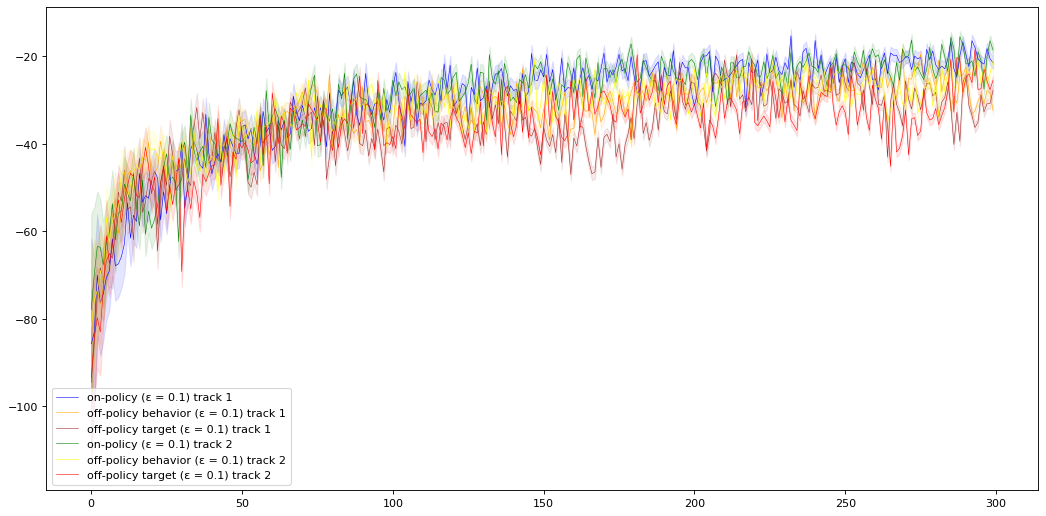

In [7]:
# Plotting code
plt.figure(figsize=(16, 8), dpi=80)

data = run_onpolicy(track1)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(data, axis=0), color='blue', linewidth=0.5, label="on-policy (ε = 0.1) track 1")
plt.fill_between(range(300), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='blue')

data, opdata = run_offpolicy(track1)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(data, axis=0), color='orange', linewidth=0.5, label="off-policy behavior (ε = 0.1) track 1")
plt.fill_between(range(300), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='orange')
rew_err = 1.96 * (np.std(np.mean(opdata, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(opdata, axis=0), color='brown', linewidth=0.5, label="off-policy target (ε = 0.1) track 1")
plt.fill_between(range(300), np.mean(opdata, axis=0) - rew_err, np.mean(opdata, axis=0) + rew_err, alpha=0.1, color='brown')

data = run_onpolicy(track2)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(data, axis=0), color='green', linewidth=0.5, label="on-policy (ε = 0.1) track 2")
plt.fill_between(range(300), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='green')

data, opdata = run_offpolicy(track2)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(data, axis=0), color='yellow', linewidth=0.5, label="off-policy behavior (ε = 0.1) track 2")
plt.fill_between(range(300), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='yellow')
rew_err = 1.96 * (np.std(np.mean(opdata, axis=0), axis=0) / np.sqrt(range(1,301)))
plt.plot(np.mean(opdata, axis=0), color='red', linewidth=0.5, label="off-policy target (ε = 0.1) track 2")
plt.fill_between(range(300), np.mean(opdata, axis=0) - rew_err, np.mean(opdata, axis=0) + rew_err, alpha=0.1, color='red')

plt.legend()